*Se saca información de los paquetes de red*

In [1]:
import dpkt # librería para procesar paquetes de red
import socket

def process_pcap(file_name):
    packets = []
    with open(file_name, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for ts, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            packet_info = {
                'File': file_name,
                'Time': ts,
                'Source': ':'.join(f"{b:02x}" for b in eth.src),
                'Destination': ':'.join(f"{b:02x}" for b in eth.dst),
                'Protocol': eth.data.__class__.__name__, #__name__ if hasattr(eth.data, 'data')
                #else eth.data.hex(),
                'Length': len(buf),
                'Info':  getattr(eth.data, 'summary', None),
            }
            packets.append(packet_info)
    return packets

# Ejemplo de uso
file_names = ['h1-traffic.pcap', 'h2-traffic.pcap']
combined_packets = []
for file_name in file_names:
    try:
        packets = process_pcap(file_name)
        combined_packets.extend(packets)
    except Exception as e:
        print(f"Error al procesar el archivo {file_name}: {str(e)}")

# Mostrar los primeros 5 paquetes para verificar
for idx, packet in enumerate(combined_packets[:26], 1):
    print(f"Paquete {idx}:")
    print(f"   File:        {packet['File']}")
    print(f"   Time:        {packet['Time']}")
    print(f"   Source:      {packet['Source']}")
    print(f"   Destination: {packet['Destination']}")
    print(f"   Protocol:    {packet['Protocol']}")
    print(f"   Length:      {packet['Length']}")
    print(f"   Info:        {packet['Info']}")
    print()  # línea en blanco entre paquetes
    
#protocolo IP: Protocolo de Internet, que se utiliza para enviar y recibir datos a través de Internet.
#Protocolo IPV6: Protocolo de Internet versión 6, que es una versión más reciente del protocolo IP, que se utiliza para la comunicación en Internet.
#Protocolo ARP: Protocolo de resolución de direcciones, que se utiliza para mapear direcciones IP a direcciones MAC en una red.



Paquete 1:
   File:        h1-traffic.pcap
   Time:        1718847010.587005
   Source:      ce:66:d5:6d:84:6e
   Destination: 33:33:00:00:00:16
   Protocol:    IP6
   Length:      90
   Info:        None

Paquete 2:
   File:        h1-traffic.pcap
   Time:        1718847010.878138
   Source:      a2:4b:5f:db:b8:92
   Destination: 33:33:ff:db:b8:92
   Protocol:    IP6
   Length:      86
   Info:        None

Paquete 3:
   File:        h1-traffic.pcap
   Time:        1718847010.943029
   Source:      5a:d7:bd:21:1c:d2
   Destination: 33:33:ff:21:1c:d2
   Protocol:    IP6
   Length:      86
   Info:        None

Paquete 4:
   File:        h1-traffic.pcap
   Time:        1718847010.983621
   Source:      5a:d7:bd:21:1c:d2
   Destination: 33:33:00:00:00:16
   Protocol:    IP6
   Length:      90
   Info:        None

Paquete 5:
   File:        h1-traffic.pcap
   Time:        1718847011.003485
   Source:      ce:66:d5:6d:84:6e
   Destination: 33:33:ff:6d:84:6e
   Protocol:    IP6
   Length: 

In [2]:
from scapy.all import rdpcap

# Cargar el archivo pcap
packets = rdpcap('h1-traffic.pcap')

# Definir la MAC objetivo
target_mac = 'ce:66:d5:6d:84:6e'

# Buscar paquetes con esa MAC
for packet in packets:
    if packet.haslayer('Ether'):
        src_mac = packet['Ether'].src.lower()
        dst_mac = packet['Ether'].dst.lower()
        
        if target_mac in [src_mac, dst_mac]:
            print(f'Paquete número: {packets.index(packet) + 1}')
            print(f'Source MAC: {src_mac}, Destination MAC: {dst_mac}')
            if packet.haslayer('IP'):
                print(f'Source IP: {packet["IP"].src}, Destination IP: {packet["IP"].dst}')
            print(f'Protocol: {packet.payload.name}\n')


Paquete número: 1
Source MAC: ce:66:d5:6d:84:6e, Destination MAC: 33:33:00:00:00:16
Protocol: IPv6

Paquete número: 5
Source MAC: ce:66:d5:6d:84:6e, Destination MAC: 33:33:ff:6d:84:6e
Protocol: IPv6

Paquete número: 6
Source MAC: ce:66:d5:6d:84:6e, Destination MAC: a2:4b:5f:db:b8:92
Source IP: 10.0.0.1, Destination IP: 10.0.0.2
Protocol: IP

Paquete número: 7
Source MAC: a2:4b:5f:db:b8:92, Destination MAC: ce:66:d5:6d:84:6e
Source IP: 10.0.0.2, Destination IP: 10.0.0.1
Protocol: IP

Paquete número: 12
Source MAC: ce:66:d5:6d:84:6e, Destination MAC: 33:33:00:00:00:16
Protocol: IPv6

Paquete número: 13
Source MAC: ce:66:d5:6d:84:6e, Destination MAC: 33:33:00:00:00:02
Protocol: IPv6

Paquete número: 12
Source MAC: ce:66:d5:6d:84:6e, Destination MAC: 33:33:00:00:00:16
Protocol: IPv6

Paquete número: 17
Source MAC: ce:66:d5:6d:84:6e, Destination MAC: a2:4b:5f:db:b8:92
Source IP: 10.0.0.1, Destination IP: 10.0.0.2
Protocol: IP

Paquete número: 18
Source MAC: a2:4b:5f:db:b8:92, Destination MA

In [2]:
import pyshark # librería para analizar archivos pcap
import pandas as pd # librería para análisis de datos
import nest_asyncio # librería para permitir el uso de asyncio en entornos no asincrónicos
nest_asyncio.apply() # Permitir el uso de asyncio en entornos no asincrónicos



def format_mac_address(mac):
    # Función para formatear la dirección MAC
    if mac is None:
        return None
    # Verificar si ya es una cadena y no una secuencia de bytes
    if isinstance(mac, str):
        return mac  # Devolver tal cual si ya es una cadena
    return ':'.join(f"{b:02x}" for b in mac)

def load_features_from_pcap(file_name):
    cap = pyshark.FileCapture(file_name)
    data = []
    for pkt in cap:
        try:
            # Usar el campo 'eth.src' y 'eth.dst' directamente si están disponibles
            src_mac = format_mac_address(pkt.eth.src)
            dst_mac = format_mac_address(pkt.eth.dst)
            protocol = pkt.highest_layer  # Usar highest_layer en lugar de transport_layer para obtener el protocolo
            data.append([src_mac, dst_mac, protocol])
        except AttributeError:
            pass  # Ignorar paquetes sin atributos de MAC válidos
    cap.close()

    return pd.DataFrame(data, columns=['Source', 'Destination', 'Protocol'])

# Función para mostrar datos en formato de tabla con formato específico y rango específico
def mostrar_datos_en_formato(data, desde, hasta):
    if data.empty:
        print("No hay datos para mostrar.")
    else:
        # Imprimir encabezados
        print(f"{'Source':<18} {'Destination':<18} Protocol")
        print("="*50)
        # Imprimir datos en el rango especificado
        for i, row in data.iloc[desde-1:hasta].iterrows():
            print(f"{row['Source']:<18} {row['Destination']:<18} {row['Protocol']}")

# Cargar características desde los archivos pcap
data_h1 = load_features_from_pcap('h1-traffic.pcap')
data_h2 = load_features_from_pcap('h2-traffic.pcap')

# Definir el rango de filas a mostrar
desde = 25
hasta = 30

# Mostrar el rango especificado en formato de tabla
print(f"Datos cargados desde h1-traffic.pcap (filas {desde} a {hasta}):")
mostrar_datos_en_formato(data_h1, desde, hasta)

print(f"\nDatos cargados desde h2-traffic.pcap (filas {desde} a {hasta}):")
mostrar_datos_en_formato(data_h2, desde, hasta)



Datos cargados desde h1-traffic.pcap (filas 25 a 30):
Source             Destination        Protocol
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ARP
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ARP
a2:4b:5f:db:b8:92  33:33:00:00:00:02  ICMPV6
5a:d7:bd:21:1c:d2  33:33:00:00:00:02  ICMPV6
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP

Datos cargados desde h2-traffic.pcap (filas 25 a 30):
Source             Destination        Protocol
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ARP
a2:4b:5f:db:b8:92  33:33:00:00:00:02  ICMPV6
86:4f:2b:ac:d2:1e  33:33:00:00:00:02  ICMPV6
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP
ce:66:d5:6d:84:6e  33:33:00:00:00:02  ICMPV6


In [3]:
import pyshark # librería para analizar archivos pcap
import pandas as pd # librería para análisis de datos

def format_mac_address(mac):
    if mac is None:
        return None
    if isinstance(mac, str):
        return mac
    return ':'.join(f"{b:02x}" for b in mac)

def load_features_from_pcap(file_name):
    cap = pyshark.FileCapture(file_name)
    data = []
    for pkt in cap:
        try:
            src_mac = format_mac_address(pkt.eth.src)
            dst_mac = format_mac_address(pkt.eth.dst)
            protocol = pkt.highest_layer
            length = int(pkt.length)
            duration = float(pkt.frame_info.time_delta)
            data.append([src_mac, dst_mac, protocol, length, duration])
        except AttributeError:
            pass
    cap.close()
    return pd.DataFrame(data, columns=['Source', 'Destination', 'Protocol', 'Length', 'Duration'])

def format_duration(duration):
    # Función para formatear la duración en segundos completos
    return f"{duration:.6f}"  # Mostrar la duración con 6 decimales

def mostrar_datos_en_formato(data, desde, hasta, etiquetas):
    if data.empty:
        print("No hay datos para mostrar.")
    else:
        print(f"{'Source':<18} {'Destination':<18} Protocol {'Length':<8} {'Duration (s)':<15} {'Label':<8}")
        print("="*90)
        for i, (index, row) in enumerate(data.iloc[desde-1:hasta].iterrows(), start=1):
            label = etiquetas[index]
            duration_seconds = format_duration(row['Duration'])
            print(f"{row['Source']:<18} {row['Destination']:<18} {row['Protocol']:<10} {row['Length']:<8} {duration_seconds:<15} {label}")

data_h1 = load_features_from_pcap('h1-traffic.pcap')
data_h2 = load_features_from_pcap('h2-traffic.pcap')

true_labels_h1 = [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
true_labels_h2 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

print("Ejemplo de etiquetas verdaderas para h1-traffic.pcap:")
print(true_labels_h1[:25])

print("\nEjemplo de etiquetas verdaderas para h2-traffic.pcap:")
print(true_labels_h2[:25])

print("\nDatos cargados desde h1-traffic.pcap:")
mostrar_datos_en_formato(data_h1, 20, 25, true_labels_h1)

print("\nDatos cargados desde h2-traffic.pcap:")
mostrar_datos_en_formato(data_h2, 20, 25, true_labels_h2)



Ejemplo de etiquetas verdaderas para h1-traffic.pcap:
[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]

Ejemplo de etiquetas verdaderas para h2-traffic.pcap:
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Datos cargados desde h1-traffic.pcap:
Source             Destination        Protocol Length   Duration (s)    Label   
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000045        0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.017914        1
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000035        0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.038492        0
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000038        1
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ARP        42       0.094680        0

Datos cargados desde h2-traffic.pcap:
Source             Destination        Protocol Length   Duration (s)    Label   
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP 

In [4]:
import pyshark # librería para analizar archivos pcap
import pandas as pd # librería para análisis de datos
import nest_asyncio # librería para permitir el uso de asyncio en entornos no asincrónicos
nest_asyncio.apply() # Permitir el uso de asyncio en entornos no asincrónicos

def format_mac_address(mac):
    if mac is None:
        return None
    if isinstance(mac, str):
        return mac
    return ':'.join(f"{b:02x}" for b in mac)

def load_features_from_pcap(file_name):
    cap = pyshark.FileCapture(file_name)
    data = []
    packet_count = 0
    byte_count = 0
    connection_set = set()

    for pkt in cap:
        try:
            src_mac = format_mac_address(pkt.eth.src)
            dst_mac = format_mac_address(pkt.eth.dst)
            protocol = pkt.highest_layer
            length = int(pkt.length)
            duration = float(pkt.frame_info.time_delta)
            
            # Calculamos la cantidad de paquetes por segundo
            packet_count += 1
            packets_per_second = packet_count / duration if duration > 0 else 0
            
            # Contamos las conexiones únicas (por ejemplo, basado en direcciones IP)
            connection_set.add((src_mac, dst_mac))
            active_connections = len(connection_set)
            
            # Calculamos el ancho de banda utilizado (en bytes)
            byte_count += length
            bandwidth_usage = byte_count / duration if duration > 0 else 0
            
            data.append([src_mac, dst_mac, protocol, length, duration, packets_per_second, active_connections, bandwidth_usage])
        except AttributeError:
            pass
    
    cap.close()
    return pd.DataFrame(data, columns=['Source', 'Destination', 'Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage'])

# Función para formatear la duración en segundos completos
def format_duration(duration):
    return f"{duration:.6f}"  # Mostrar la duración con 6 decimales

# Función para mostrar los datos en un formato tabular
def mostrar_datos_en_formato(data, desde, hasta, etiquetas):
    if data.empty:
        print("No hay datos para mostrar.")
    else:
        print(f"{'Source':<18} {'Destination':<18} Protocol {'Length':<8} {'Duration (s)':<15} {'Packets/s':<12} {'Active Conns':<14} {'Bandwidth (B/s)':<16} {'Label':<8}")
        print("="*130)
        for i, (index, row) in enumerate(data.iloc[desde-1:hasta].iterrows(), start=1):
            label = etiquetas[index]
            duration_seconds = format_duration(row['Duration'])
            print(f"{row['Source']:<18} {row['Destination']:<18} {row['Protocol']:<10} {row['Length']:<8} {duration_seconds:<15} {row['PacketsPerSecond']:<12.2f} {row['ActiveConnections']:<14} {row['BandwidthUsage']:<16.2f} {label}")

# Ejemplo de uso
data_h1 = load_features_from_pcap('h1-traffic.pcap')
data_h2 = load_features_from_pcap('h2-traffic.pcap')

true_labels_h1 = [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
true_labels_h2 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

print("Ejemplo de etiquetas verdaderas para h1-traffic.pcap:")
print(true_labels_h1[:25])

print("\nEjemplo de etiquetas verdaderas para h2-traffic.pcap:")
print(true_labels_h2[:25])

print("\nDatos cargados desde h1-traffic.pcap:")
mostrar_datos_en_formato(data_h1, 20, 25, true_labels_h1)

print("\nDatos cargados desde h2-traffic.pcap:")
mostrar_datos_en_formato(data_h2, 20, 25, true_labels_h2)

#PacketsPerSecond: Cantidad de paquetes por segundo.
#ActiveConnections: Número de conexiones activas únicas observadas.
#BandwidthUsage: Ancho de banda utilizado en bytes por segundo.

#en label se indica si el tráfico es normal (0) o anómalo (1).

Ejemplo de etiquetas verdaderas para h1-traffic.pcap:
[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]

Ejemplo de etiquetas verdaderas para h2-traffic.pcap:
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Datos cargados desde h1-traffic.pcap:
Source             Destination        Protocol Length   Duration (s)    Packets/s    Active Conns   Bandwidth (B/s)  Label   
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000045        444444.44    11             39466666.67      0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.017914        20.63        11             1841.02          1
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000035        628571.43    11             56342857.14      0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.038492        22.15        11             1993.27          0
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000038        631578.95    11 

In [5]:
true_labels_h1 = [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
true_labels_h2 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# Formatear duración en segundos completos
data_h1['Duration'] = data_h1['Duration'].apply(format_duration)
data_h2['Duration'] = data_h2['Duration'].apply(format_duration)

# Crear DataFrames con los primeros 25 datos y etiquetas
df_h1 = pd.concat([data_h1.head(25), pd.Series(true_labels_h1[:25], name='Label')], axis=1)
df_h2 = pd.concat([data_h2.head(25), pd.Series(true_labels_h2[:25], name='Label')], axis=1)

# Unir ambos DataFrames en uno solo
df_combined = pd.concat([df_h1, df_h2])

# Guardar DataFrame combinado en un archivo CSV
df_combined.to_csv('combined-traffic-labels.csv', index=False)

print("Archivo CSV guardado exitosamente: combined-traffic-labels.csv")



Archivo CSV guardado exitosamente: combined-traffic-labels.csv


In [6]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# Cargar el dataset
df = pd.read_csv('combined-traffic-labels.csv')

# Seleccionar características relevantes
features = df[['Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]

# Entrenar el modelo
iso_forest = IsolationForest(contamination=0.1)  # Ajusta el parámetro 'contamination' según tu caso
df['AnomalyPrediction'] = iso_forest.fit_predict(features)

# Etiquetar anomalías
df['AnomalyLabel'] = df['AnomalyPrediction'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# Guardar los resultados
df.to_csv('anomaly_detection_results.csv', index=False)


In [7]:
import pandas as pd # Para el análisis de datos


# Cargar los datos desde el archivo CSV
file_path = '/tmp/pycharm_project_282/combined-traffic-labels.csv'
df = pd.read_csv(file_path)

# Imprimir las primeras filas para verificar que los datos se han cargado correctamente
print(df.head())


              Source        Destination Protocol  Length  Duration  \
0  ce:66:d5:6d:84:6e  33:33:00:00:00:16   ICMPV6      90  0.000000   
1  a2:4b:5f:db:b8:92  33:33:ff:db:b8:92   ICMPV6      86  0.291133   
2  5a:d7:bd:21:1c:d2  33:33:ff:21:1c:d2   ICMPV6      86  0.064891   
3  5a:d7:bd:21:1c:d2  33:33:00:00:00:16   ICMPV6      90  0.040592   
4  ce:66:d5:6d:84:6e  33:33:ff:6d:84:6e   ICMPV6      86  0.019864   

   PacketsPerSecond  ActiveConnections  BandwidthUsage  Label  
0          0.000000                  1        0.000000      0  
1          6.869712                  2      604.534697      1  
2         46.231373                  3     4037.539875      0  
3         98.541585                  4     8671.659440      1  
4        251.711639                  5    22049.939589      1  


In [8]:
import pandas as pd

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Verificar los primeros registros y las columnas disponibles
df.head()


,Source,Destination,Protocol,Length,Duration,PacketsPerSecond,ActiveConnections,BandwidthUsage,Label
0,ce:66:d5:6d:84:6e,33:33:00:00:00:16,ICMPV6,90,0.000000,0.000000,1,0.000000,0
1,a2:4b:5f:db:b8:92,33:33:ff:db:b8:92,ICMPV6,86,0.291133,6.869712,2,604.534697,1
2,5a:d7:bd:21:1c:d2,33:33:ff:21:1c:d2,ICMPV6,86,0.064891,46.231373,3,4037.539875,0
3,5a:d7:bd:21:1c:d2,33:33:00:00:00:16,ICMPV6,90,0.040592,98.541585,4,8671.659440,1
4,ce:66:d5:6d:84:6e,33:33:ff:6d:84:6e,ICMPV6,86,0.019864,251.711639,5,22049.939589,1


In [9]:
import pandas as pd

# Cargar los datos desde el archivo CSV
file_path = '/tmp/pycharm_project_282/combined-traffic-labels.csv'  
df = pd.read_csv(file_path)

# Mostrar las primeras filas para entender la estructura de los datos
print(df.head(7))

# Información general sobre el dataset
print(df.info())

# Estadísticas descriptivas básicas
print(df.describe())


              Source        Destination Protocol  Length  Duration  \
0  ce:66:d5:6d:84:6e  33:33:00:00:00:16   ICMPV6      90  0.000000   
1  a2:4b:5f:db:b8:92  33:33:ff:db:b8:92   ICMPV6      86  0.291133   
2  5a:d7:bd:21:1c:d2  33:33:ff:21:1c:d2   ICMPV6      86  0.064891   
3  5a:d7:bd:21:1c:d2  33:33:00:00:00:16   ICMPV6      90  0.040592   
4  ce:66:d5:6d:84:6e  33:33:ff:6d:84:6e   ICMPV6      86  0.019864   
5  ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92     ICMP      98  0.327313   
6  a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e     ICMP      98  0.000045   

   PacketsPerSecond  ActiveConnections  BandwidthUsage  Label  
0          0.000000                  1    0.000000e+00      0  
1          6.869712                  2    6.045347e+02      1  
2         46.231373                  3    4.037540e+03      0  
3         98.541585                  4    8.671659e+03      1  
4        251.711639                  5    2.204994e+04      1  
5         18.331078                  6    1.637576e+03 

In [10]:
#3.2 Proceso de implementacion
#Deteccion de anomalias


import pandas as pd
from sklearn.model_selection import train_test_split # librería para dividir los datos en entrenamiento y prueba
from sklearn.preprocessing import OneHotEncoder # librería para codificar características categóricas en numéricas

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder para convertirla en numérica y poder usarla en el modelo
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Dividir los datos en entrenamiento y prueba para evaluar el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



*se entrena un modelo de detección de anomalías utilizando el algoritmo Isolation Forest.*

Matriz de confusión (Fracción 0.20):
[[4 1]
 [2 3]]


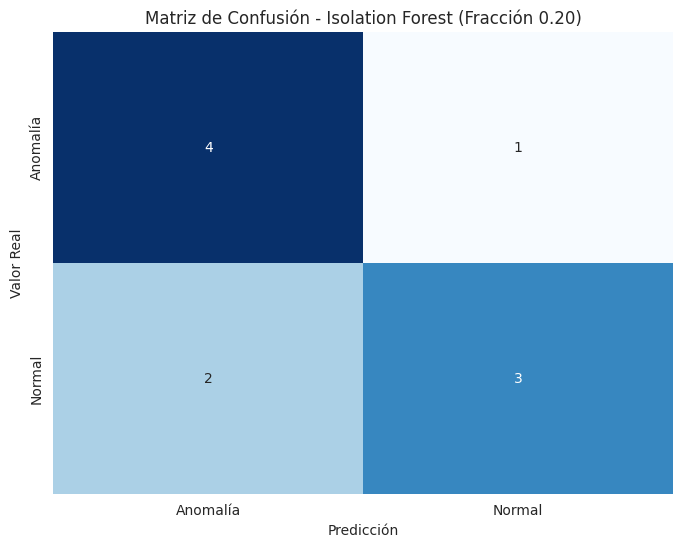

Matriz de confusión (Fracción 0.50):
[[10  2]
 [ 7  6]]


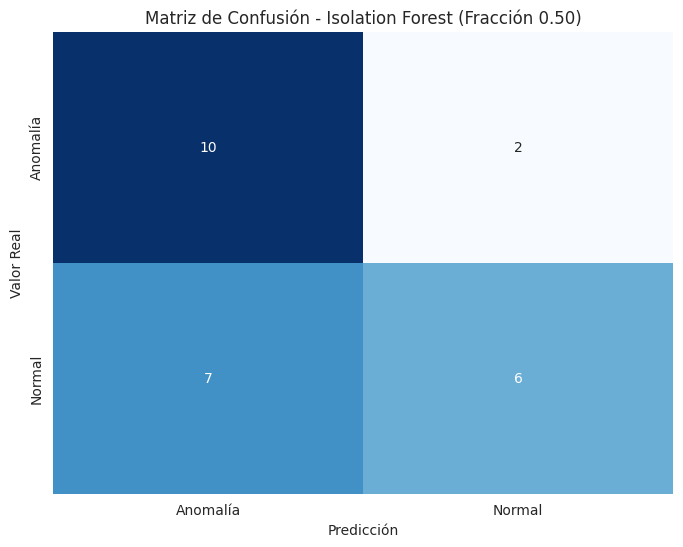

Matriz de confusión (Fracción 0.80):
[[14  6]
 [ 9 11]]


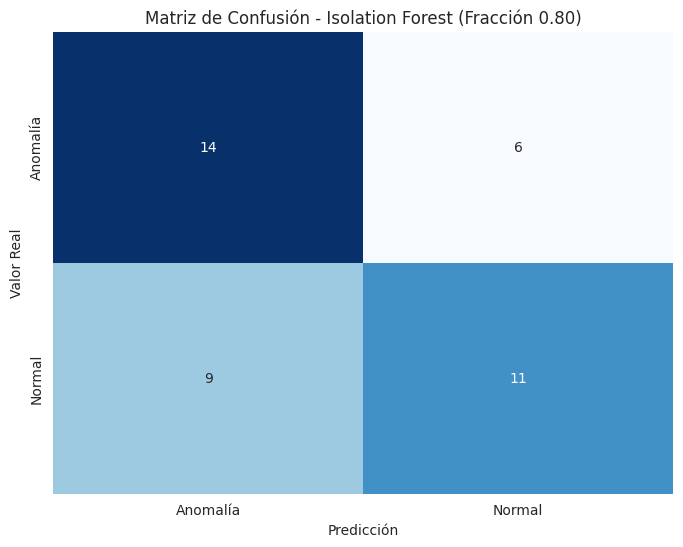

Matriz de confusión (Fracción 1.00):
[[19  7]
 [14 10]]


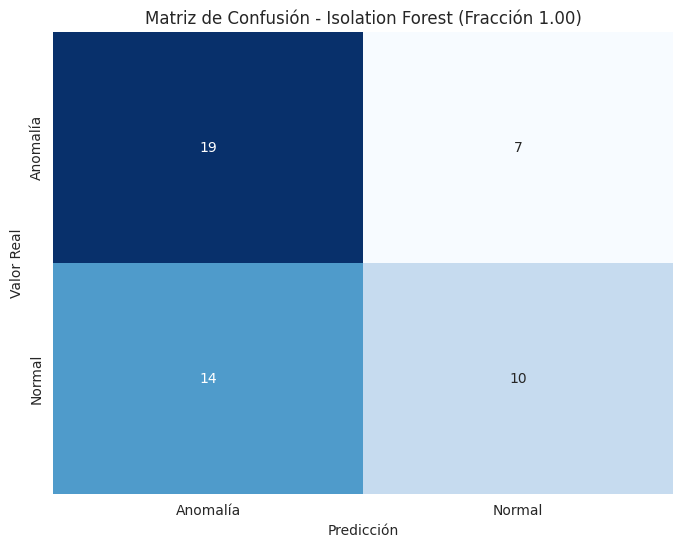

Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:
Fracción del conjunto de datos: 0.20
Precisión: 0.67
Recall: 0.80
F1-score: 0.73
Exactitud (Accuracy): 0.70
Tiempo de entrenamiento: 0.17 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 4.10%
Uso de Memoria (RSS): 240.68 MB
Uso de Memoria (VMS): 1140.89 MB
------------------------------
Fracción del conjunto de datos: 0.50
Precisión: 0.59
Recall: 0.83
F1-score: 0.69
Exactitud (Accuracy): 0.64
Tiempo de entrenamiento: 0.33 segundos
Tiempo de ejecución: 0.01 segundos
Uso de CPU: 3.10%
Uso de Memoria (RSS): 243.18 MB
Uso de Memoria (VMS): 1143.43 MB
------------------------------
Fracción del conjunto de datos: 0.80
Precisión: 0.61
Recall: 0.70
F1-score: 0.65
Exactitud (Accuracy): 0.62
Tiempo de entrenamiento: 0.31 segundos
Tiempo de ejecución: 0.01 segundos
Uso de CPU: 4.10%
Uso de Memoria (RSS): 244.81 MB
Uso de Memoria (VMS): 1144.85 MB
------------------------------
Fracción del conjunto de datos: 1.00
Precisi

In [11]:
#Insolation Forest (Bosque de Aislamiento)
#sirve para detectar anomalías en los datos, es decir, puntos que son significativamente diferentes del resto de los datos.
#Es un algoritmo de aprendizaje no supervisado que se basa en la construcción de múltiples árboles de decisión durante el entrenamiento.

import pandas as pd
import time
import psutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Crear una lista para almacenar los resultados
results = []

# Evaluar el modelo con diferentes fracciones del conjunto de datos
fractions = [0.2, 0.5, 0.8, 1.0]
for fraction in fractions:
    # Seleccionar una fracción del conjunto de datos
    X_frac = X.sample(frac=fraction, random_state=42) # Seleccionar una fracción aleatoria del conjunto de datos
    y_frac = y[X_frac.index]
    
    # Crear y ajustar el modelo Isolation Forest
    iforest = IsolationForest(random_state=42)
    start_training_time = time.time()
    iforest.fit(X_frac, y_frac)
    training_time = time.time() - start_training_time
    
    # Obtener predicciones para la fracción del conjunto de datos
    start_execution_time = time.time()
    predictions = iforest.predict(X_frac)
    execution_time = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    predictions = [0 if x == -1 else 1 for x in predictions]
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_frac, predictions, labels=[1, 0])
    print(f"Matriz de confusión (Fracción {fraction:.2f}):\n{cm}")
    
    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
                xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
    plt.title(f'Matriz de Confusión - Isolation Forest (Fracción {fraction:.2f})')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    
    # Calcular las métricas de evaluación manualmente
    precision = precision_score(y_frac, predictions, zero_division=0)
    recall = recall_score(y_frac, predictions, zero_division=0)
    f1 = f1_score(y_frac, predictions, zero_division=0)
    accuracy = accuracy_score(y_frac, predictions)
    
    # Medir uso de CPU y memoria
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.Process(os.getpid()).memory_info()
    
    # Almacenar los resultados
    results.append({
        'fraction': fraction,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'training_time': training_time,
        'execution_time': execution_time,
        'cpu_usage': cpu_usage,
        'memory_rss': memory_info.rss / 1024 ** 2,
        'memory_vms': memory_info.vms / 1024 ** 2
    })

# Imprimir resultados
print("Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:")
for result in results:
    print(f"Fracción del conjunto de datos: {result['fraction']:.2f}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print(f"Uso de CPU: {result['cpu_usage']:.2f}%")
    print(f"Uso de Memoria (RSS): {result['memory_rss']:.2f} MB")
    print(f"Uso de Memoria (VMS): {result['memory_vms']:.2f} MB")
    print("-" * 30)


In [12]:
#Verdaderos Positivos: 19 (El modelo identifico correctamente 19 anomalías)
#Falsos Negativos: 7 (El modelo no identifico 7 anomalías, prediciéndola como normal)
#Falsos Positivos: 14 (El modelo cometió un error al no detectar 14 instancias que eran normales y las clasificó como anomalías)
#Verdaderos Negativos: 10 (El modelo detecto correctamente 10 instancias normales)

*se entrena un modelo de detección de anomalías utilizando el algoritmo One-Class SVM.*

In [13]:
import pandas as pd
import time
import psutil
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Cargar los datos desde el CSV
df = pd.read_csv('combined-traffic-labels.csv')



# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Usa sparse_output=False en lugar de sparse
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)


# Crear una lista para almacenar los resultados
results = []

# Evaluar el modelo con diferentes fracciones del conjunto de datos
fractions = [0.2, 0.5, 0.8, 1.0]
for fraction in fractions:
    print(f"\nEvaluando fracción del conjunto de datos: {fraction:.2f}")

    # Seleccionar una fracción del conjunto de datos
    X_frac = X.sample(frac=fraction, random_state=42)
    y_frac = y.loc[X_frac.index]
    
    # Verifica el tamaño del conjunto de datos fraccionado
    print(f"Tamaño del conjunto de datos fraccionado: {len(X_frac)}")
    
    # Crear y ajustar el modelo One-Class SVM
    oc_svm = OneClassSVM(kernel='rbf', gamma='auto')
    start_training_time = time.time()
    oc_svm.fit(X_frac)
    training_time = time.time() - start_training_time
    
    # Obtener predicciones para la fracción del conjunto de datos
    start_execution_time = time.time()
    predictions = oc_svm.predict(X_frac)
    execution_time = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    predictions = [0 if x == -1 else 1 for x in predictions]
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_frac, predictions, labels=[1, 0])
    print(f"Matriz de confusión:\n{cm}")
    tn, fp, fn, tp = cm.ravel()
    
    # Calcular las métricas de evaluación
    precision = precision_score(y_frac, predictions, zero_division=0)
    recall = recall_score(y_frac, predictions, zero_division=0)
    f1 = f1_score(y_frac, predictions, zero_division=0)
    accuracy = accuracy_score(y_frac, predictions)
    
    # Medir uso de CPU y memoria
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.Process(os.getpid()).memory_info()
    
    # Almacenar los resultados
    results.append({
        'fraction': fraction,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'training_time': training_time,
        'execution_time': execution_time,
        'cpu_usage': cpu_usage,
        'memory_rss': memory_info.rss / 1024 ** 2,
        'memory_vms': memory_info.vms / 1024 ** 2
    })

# Imprimir resultados
print("\nEvaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:")
for result in results:
    print(f"Fracción del conjunto de datos: {result['fraction']:.2f}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print(f"Uso de CPU: {result['cpu_usage']:.2f}%")
    print(f"Uso de Memoria (RSS): {result['memory_rss']:.2f} MB")
    print(f"Uso de Memoria (VMS): {result['memory_vms']:.2f} MB")
    print("-" * 30)





Evaluando fracción del conjunto de datos: 0.20
Tamaño del conjunto de datos fraccionado: 10
Matriz de confusión:
[[0 5]
 [0 5]]

Evaluando fracción del conjunto de datos: 0.50
Tamaño del conjunto de datos fraccionado: 25
Matriz de confusión:
[[ 0 12]
 [ 0 13]]

Evaluando fracción del conjunto de datos: 0.80
Tamaño del conjunto de datos fraccionado: 40
Matriz de confusión:
[[ 3 17]
 [ 2 18]]

Evaluando fracción del conjunto de datos: 1.00
Tamaño del conjunto de datos fraccionado: 50
Matriz de confusión:
[[11 15]
 [12 12]]

Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:
Fracción del conjunto de datos: 0.20
Precisión: 0.00
Recall: 0.00
F1-score: 0.00
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.01 segundos
Uso de CPU: 2.10%
Uso de Memoria (RSS): 243.95 MB
Uso de Memoria (VMS): 1143.43 MB
------------------------------
Fracción del conjunto de datos: 0.50
Precisión: 0.00
Recall: 0.00
F1-score: 0.00
Exactitud (Accuracy): 0.52


Evaluando fracción del conjunto de datos: 1.00
Tamaño del conjunto de datos fraccionado: 50
Matriz de confusión:
[[11 15]
 [12 12]]

Resultados para fracción del conjunto de datos: 1.00
Precisión: 0.48
Recall: 0.42
F1-score: 0.45
Exactitud (Accuracy): 0.46
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 5.10%
Uso de Memoria (RSS): 244.08 MB
Uso de Memoria (VMS): 1143.43 MB


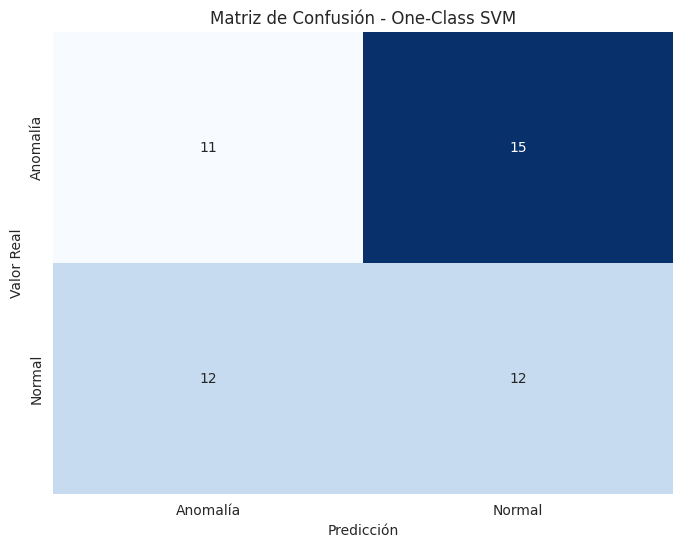

In [14]:
#SVM (Máquina de Vectores de Soporte)
#sirve para clasificar datos en dos categorías, pero también puede ser utilizada para detectar anomalías en datos no etiquetados,
#es decir, datos que no tienen una etiqueta de clase asociada. En este caso, la SVM se entrena para encontrar un límite de decisión
#que separe los datos normales de los datos anómalos en un espacio de alta dimensión.
#es un algoritmo de aprendizaje supervisado que se puede utilizar para clasificación y regresión.

import pandas as pd
import time
import psutil
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos desde el CSV
df = pd.read_csv('combined-traffic-labels.csv')


# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Usa sparse_output=False en lugar de sparse
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)



# Evaluar el modelo con una fracción del conjunto de datos
fraction = 1.0
print(f"\nEvaluando fracción del conjunto de datos: {fraction:.2f}")

# Seleccionar una fracción del conjunto de datos
X_frac = X.sample(frac=fraction, random_state=42)
y_frac = y.loc[X_frac.index]

# Verifica el tamaño del conjunto de datos fraccionado
print(f"Tamaño del conjunto de datos fraccionado: {len(X_frac)}")

# Crear y ajustar el modelo One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='auto')
start_training_time = time.time()
oc_svm.fit(X_frac)
training_time = time.time() - start_training_time

# Obtener predicciones para la fracción del conjunto de datos
start_execution_time = time.time()
predictions = oc_svm.predict(X_frac)
execution_time = time.time() - start_execution_time

# Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
predictions = [0 if x == -1 else 1 for x in predictions]

# Calcular la matriz de confusión
cm = confusion_matrix(y_frac, predictions, labels=[1, 0])
print(f"Matriz de confusión:\n{cm}")
tn, fp, fn, tp = cm.ravel()

# Calcular las métricas de evaluación
precision = precision_score(y_frac, predictions, zero_division=0)
recall = recall_score(y_frac, predictions, zero_division=0)
f1 = f1_score(y_frac, predictions, zero_division=0)
accuracy = accuracy_score(y_frac, predictions)

# Medir uso de CPU y memoria
cpu_usage = psutil.cpu_percent(interval=1)
memory_info = psutil.Process(os.getpid()).memory_info()

# Imprimir resultados
print(f"\nResultados para fracción del conjunto de datos: {fraction:.2f}")
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
print(f"Uso de CPU: {cpu_usage:.2f}%")
print(f"Uso de Memoria (RSS): {memory_info.rss / 1024 ** 2:.2f} MB")
print(f"Uso de Memoria (VMS): {memory_info.vms / 1024 ** 2:.2f} MB")

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
plt.title('Matriz de Confusión - One-Class SVM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


In [15]:
#Verdaderos Positivos: 11 (El modelo identifico correctamente 11 anomalías)
#Falsos Negativos: 15 (El modelo no identifico 15 anomalías, prediciéndola como normal)
#Falsos Positivos: 12 (El modelo cometió un error al no detectar 12 instancias que eran normales y las clasificó como anomalías)
#Verdaderos Negativos: 12 (El modelo detecto correctamente 12 instancias normales)
#11+12/11+12+15+12=23/50=0.46

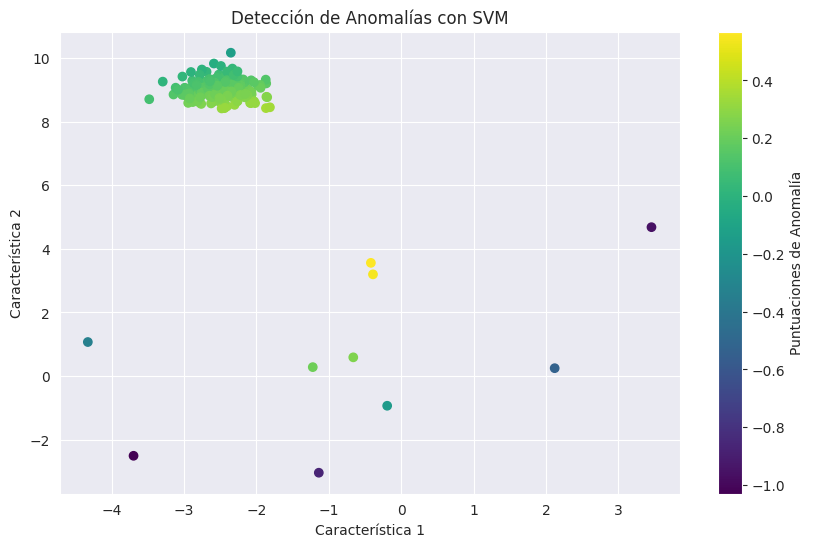

In [16]:
from sklearn.datasets import make_blobs  # librería para generar datos sintéticos
from sklearn.svm import OneClassSVM # librería para One-Class SVM
import matplotlib.pyplot as plt # librería para graficar datos
import numpy as np # librería para operaciones numéricas

# Generar datos sintéticos para demostración
X, _ = make_blobs(n_samples=200, centers=1, cluster_std=0.3, random_state=42)

# Introducir algunas anomalías
outliers = np.random.uniform(low=-5, high=5, size=(10, 2))
X = np.vstack([X, outliers])

# Ajustar el modelo One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm.fit(X)

# Obtener las puntuaciones de decisión/anomalía
svm_scores = svm.decision_function(X)

# Graficar las puntuaciones de anomalía
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=svm_scores, cmap='viridis')
plt.colorbar(label='Puntuaciones de Anomalía')
plt.title('Detección de Anomalías con SVM')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.grid(True)
plt.show()

#Los puntos más oscuros en el gráfico (colores más fríos en la barra de colores) representan las anomalías detectadas por el SVM, ya que tienen puntuaciones de anomalía más negativas.
#Los puntos más claros (colores más cálidos) son considerados menos anómalos según el modelo.


*Se entrena un modelo de detección de anomalías utilizando el algoritmo Local Outlier Factor (LOF).*


Evaluando fracción del conjunto de datos: 0.20
Tamaño del conjunto de datos fraccionado: 10
Matriz de confusión:
[[5 0]
 [5 0]]

Resultados para fracción del conjunto de datos: 0.20
Precisión: 0.50
Recall: 1.00
F1-score: 0.67
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento: 0.01 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 3.10%
Uso de Memoria (RSS): 250.80 MB
Uso de Memoria (VMS): 1253.88 MB


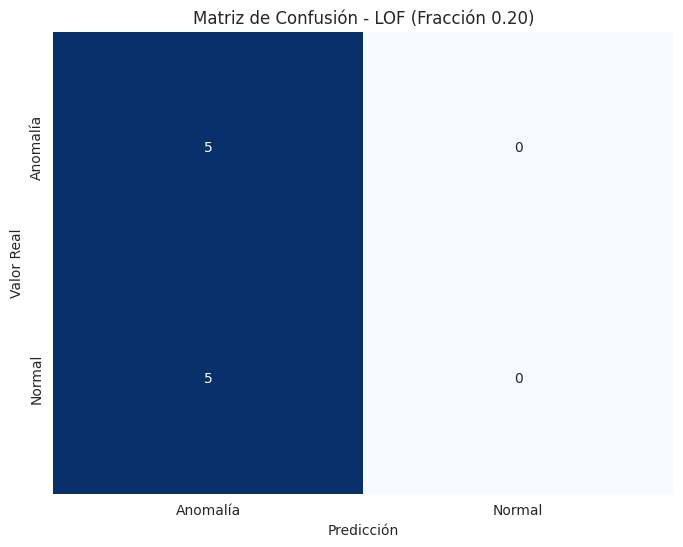


Evaluando fracción del conjunto de datos: 0.50
Tamaño del conjunto de datos fraccionado: 25
Matriz de confusión:
[[10  2]
 [13  0]]

Resultados para fracción del conjunto de datos: 0.50
Precisión: 0.43
Recall: 0.83
F1-score: 0.57
Exactitud (Accuracy): 0.40
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 5.80%
Uso de Memoria (RSS): 253.93 MB
Uso de Memoria (VMS): 1257.87 MB


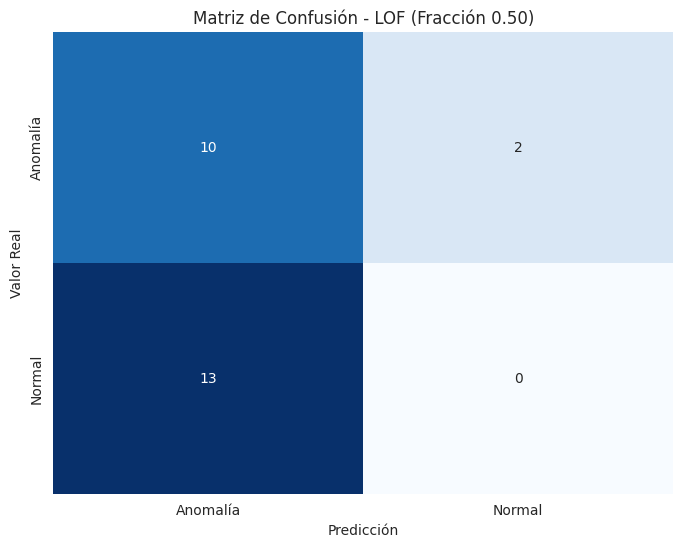


Evaluando fracción del conjunto de datos: 0.80
Tamaño del conjunto de datos fraccionado: 40
Matriz de confusión:
[[12  8]
 [12  8]]

Resultados para fracción del conjunto de datos: 0.80
Precisión: 0.50
Recall: 0.60
F1-score: 0.55
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento: 0.01 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 4.70%
Uso de Memoria (RSS): 255.68 MB
Uso de Memoria (VMS): 1259.29 MB


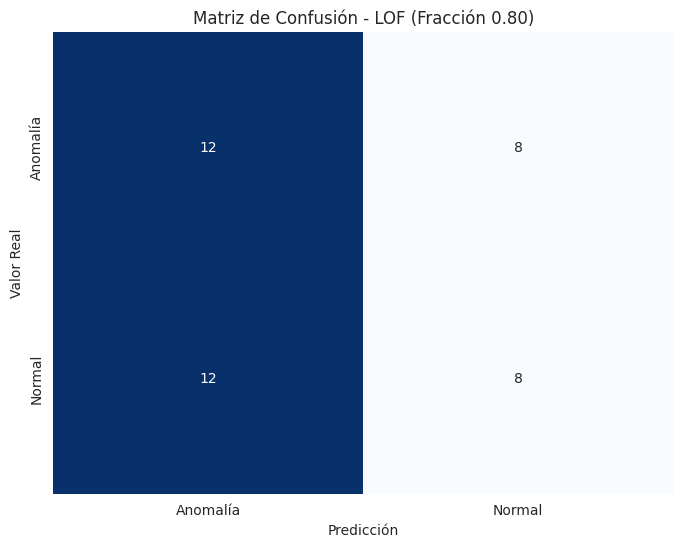


Evaluando fracción del conjunto de datos: 1.00
Tamaño del conjunto de datos fraccionado: 50
Matriz de confusión:
[[13 13]
 [16  8]]

Resultados para fracción del conjunto de datos: 1.00
Precisión: 0.45
Recall: 0.50
F1-score: 0.47
Exactitud (Accuracy): 0.42
Tiempo de entrenamiento: 0.01 segundos
Tiempo de ejecución: 0.01 segundos
Uso de CPU: 3.60%
Uso de Memoria (RSS): 257.93 MB
Uso de Memoria (VMS): 1260.97 MB


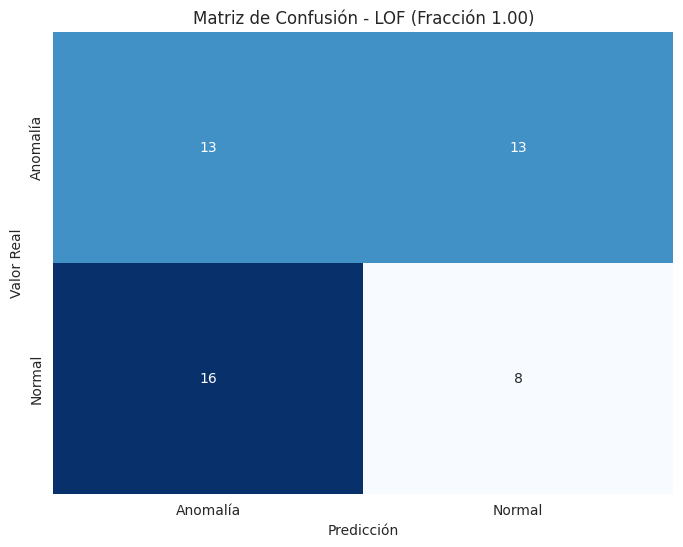

In [17]:
# Local Outlier Factor (LOF)
# LOF es un algoritmo de detección de anomalías que estima la densidad de los vecinos más cercanos y la compara con la densidad local de un punto específico. 
# Si la densidad de un punto es significativamente menor que la densidad de sus vecinos, es considerado una anomalía.

import pandas as pd
import time
import psutil
import os
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos desde el CSV
df = pd.read_csv('combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Fracciones del conjunto de datos a evaluar
fractions = [0.20, 0.50, 0.80, 1.0]

for fraction in fractions:
    print(f"\nEvaluando fracción del conjunto de datos: {fraction:.2f}")

    # Seleccionar una fracción del conjunto de datos
    X_frac = X.sample(frac=fraction, random_state=42)
    y_frac = y.loc[X_frac.index]

    # Verificar el tamaño del conjunto de datos fraccionado
    print(f"Tamaño del conjunto de datos fraccionado: {len(X_frac)}")

    # Crear y ajustar el modelo LOF
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="X does not have valid feature names")
        lof = LocalOutlierFactor(n_neighbors=min(20, len(X_frac) - 1), novelty=True)
        start_training_time = time.time()
        lof.fit(X_frac)  # Ajuste con X_frac, que tiene nombres de características
        training_time = time.time() - start_training_time

    # Predecir usando las mismas características con nombres válidos
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="X does not have valid feature names")
        start_execution_time = time.time()
        predictions = lof.predict(X_frac)
        execution_time = time.time() - start_execution_time

    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    predictions = [0 if x == -1 else 1 for x in predictions]

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_frac, predictions, labels=[1, 0])
    print(f"Matriz de confusión:\n{cm}")
    tn, fp, fn, tp = cm.ravel()

    # Calcular las métricas de evaluación
    precision = precision_score(y_frac, predictions, zero_division=0)
    recall = recall_score(y_frac, predictions, zero_division=0)
    f1 = f1_score(y_frac, predictions, zero_division=0)
    accuracy = accuracy_score(y_frac, predictions)

    # Medir uso de CPU y memoria
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.Process(os.getpid()).memory_info()

    # Imprimir resultados
    print(f"\nResultados para fracción del conjunto de datos: {fraction:.2f}")
    print(f"Precisión: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"Exactitud (Accuracy): {accuracy:.2f}")
    print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")
    print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
    print(f"Uso de CPU: {cpu_usage:.2f}%")
    print(f"Uso de Memoria (RSS): {memory_info.rss / 1024 ** 2:.2f} MB")
    print(f"Uso de Memoria (VMS): {memory_info.vms / 1024 ** 2:.2f} MB")

    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
                xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
    plt.title(f'Matriz de Confusión - LOF (Fracción {fraction:.2f})')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()




Evaluando fracción del conjunto de datos: 1.00
Tamaño del conjunto de datos fraccionado: 50
Matriz de confusión:
[[13 13]
 [16  8]]


/home/kali/.virtualenvs/pythonProject/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



Resultados para fracción del conjunto de datos: 1.00
Precisión: 0.45
Recall: 0.50
F1-score: 0.47
Exactitud (Accuracy): 0.42
Tiempo de entrenamiento: 0.01 segundos
Tiempo de ejecución: 0.03 segundos
Uso de CPU: 3.20%
Uso de Memoria (RSS): 255.03 MB
Uso de Memoria (VMS): 1257.87 MB


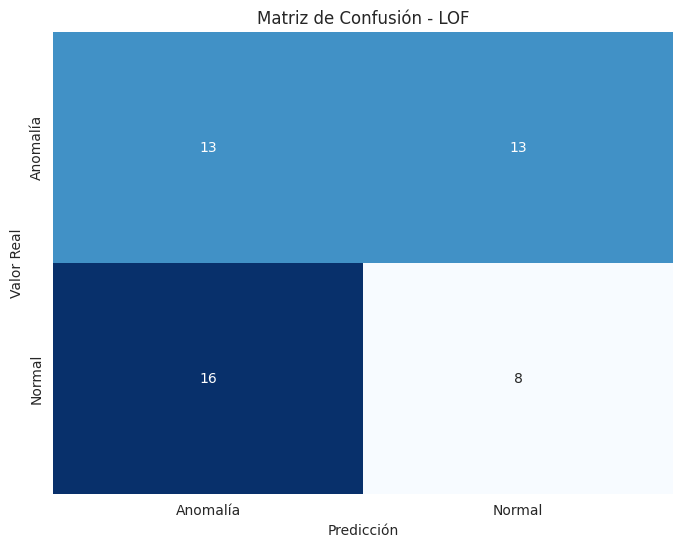

In [18]:
# LOF (Factor de Valor Atípico Local)
# El LOF es un algoritmo de detección de anomalías basado en la densidad local.
# Detecta anomalías al comparar la densidad local de un punto con la densidad local de sus vecinos.
# Es un algoritmo de aprendizaje no supervisado que puede detectar anomalías en datos no etiquetados.

import pandas as pd
import time
import psutil
import os
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos desde el CSV
df = pd.read_csv('combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Evaluar el modelo LOF con una fracción del conjunto de datos
fraction = 1.0
print(f"\nEvaluando fracción del conjunto de datos: {fraction:.2f}")

# Seleccionar una fracción del conjunto de datos
X_frac = X.sample(frac=fraction, random_state=42)
y_frac = y.loc[X_frac.index]

# Verifica el tamaño del conjunto de datos fraccionado
print(f"Tamaño del conjunto de datos fraccionado: {len(X_frac)}")

# Crear y ajustar el modelo LOF
lof = LocalOutlierFactor(n_neighbors=min(20, len(X_frac) - 1), novelty=True)
start_training_time = time.time()
lof.fit(X_frac)
training_time = time.time() - start_training_time

# Obtener predicciones para la fracción del conjunto de datos
start_execution_time = time.time()
predictions = lof.predict(X_frac)
execution_time = time.time() - start_execution_time

# Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
predictions = [1 if x == 1 else 0 for x in predictions]

# Calcular la matriz de confusión
cm = confusion_matrix(y_frac, predictions, labels=[1, 0])
print(f"Matriz de confusión:\n{cm}")
tn, fp, fn, tp = cm.ravel()

# Calcular las métricas de evaluación
precision = precision_score(y_frac, predictions, zero_division=0)
recall = recall_score(y_frac, predictions, zero_division=0)
f1 = f1_score(y_frac, predictions, zero_division=0)
accuracy = accuracy_score(y_frac, predictions)

# Medir uso de CPU y memoria
cpu_usage = psutil.cpu_percent(interval=1)
memory_info = psutil.Process(os.getpid()).memory_info()

# Imprimir resultados
print(f"\nResultados para fracción del conjunto de datos: {fraction:.2f}")
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
print(f"Uso de CPU: {cpu_usage:.2f}%")
print(f"Uso de Memoria (RSS): {memory_info.rss / 1024 ** 2:.2f} MB")
print(f"Uso de Memoria (VMS): {memory_info.vms / 1024 ** 2:.2f} MB")

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
plt.title('Matriz de Confusión - LOF')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()



In [19]:
#Verdaderos Positivos: 13 (El modelo identifico correctamente 13 anomalías)
#Falsos Negativos: 13 (El modelo no identifico 13 anomalías, prediciéndola como normal)
#Falsos Positivos: 16 (El modelo cometió un error al no detectar 16 instancias que eran normales y las clasificó como anomalías)
#Verdaderos Negativos: 8 (El modelo detecto correctamente 8 instancias normales)

In [28]:
import pandas as pd
import numpy as np

# Cargar los resultados
results_iforest = pd.read_csv('results_iforest_fraction_1.0.csv')
results_ocsvm = pd.read_csv('results_svm.csv')
results_lof = pd.read_csv('results_lof.csv')

# Concatenar resultados en un solo DataFrame
results_all = pd.concat([results_iforest, results_ocsvm, results_lof], keys=['Isolation Forest', 'One-Class SVM', 'LOF'])

# Normalización
def normalize(df):
    return df / np.sqrt((df ** 2).sum())

# Ponderación (asume que los pesos son los mismos para todos)
weights = {
    'precision': 0.25,
    'recall': 0.25,
    'f1_score': 0.25,
    'accuracy': 0.25
}

# Normalizar los datos
results_all_normalized = results_all[['precision', 'recall', 'f1_score', 'accuracy']].apply(normalize)

# Calcular el índice TOPSIS
ideal_best = results_all_normalized.max()
ideal_worst = results_all_normalized.min()

distances_best = np.sqrt(((results_all_normalized - ideal_best) ** 2).sum(axis=1))
distances_worst = np.sqrt(((results_all_normalized - ideal_worst) ** 2).sum(axis=1))

topsis_score = distances_worst / (distances_best + distances_worst)

# Añadir el puntaje TOPSIS al DataFrame
results_all['topsis_score'] = topsis_score

# Mostrar el mejor algoritmo
best_algorithm = results_all.loc[results_all.groupby(level=0)['topsis_score'].idxmax()]
print(best_algorithm)


                    fraction  precision    recall  f1_score  accuracy  \
Isolation Forest 0       1.0   0.575758  0.730769  0.644068      0.58   
LOF              0       1.0   0.448276  0.500000  0.472727      0.42   
One-Class SVM    0       1.0   0.478261  0.423077  0.448980      0.46   

                    training_time  execution_time  cpu_usage  memory_rss  \
Isolation Forest 0       0.147163        0.004689        7.6  256.531250   
LOF              0       0.003296        0.002681        2.9  268.507812   
One-Class SVM    0       0.009997        0.005392        4.7  256.531250   

                     memory_vms  topsis_score  
Isolation Forest 0  1259.292969      1.000000  
LOF              0  1268.710938      0.177205  
One-Class SVM    0  1259.292969      0.121872  


*METODOLOGIA TOPSIS PARA EVALUAR ALGORITMOS*
1. SE NORMALIZAN LOS DATOS DE CADA ALGORITMO PARA QUE TODOS TENGAN EL MISMO PESO. YA QUE CADA ALGORITMO TIENE DIFERENTES RANGOS DE VALORES.

In [33]:
import numpy as np
import pandas as pd

# Matriz de decisión (resultados originales)
matriz = np.array([
    [0.58, 0.48, 0.45],  # Precisión (Maximizar)
    [0.73, 0.42, 0.50],  # Recall (Maximizar)
    [0.64, 0.45, 0.47],  # F1-score (Maximizar)
    [0.58, 0.46, 0.42],  # Exactitud (Maximizar)
    [4.70, 5.10, 3.20],  # Uso de CPU (Minimizar)
    [243.45, 244.08, 255.03],  # Uso de Memoria (RSS) (Minimizar)
    [1143.43, 1143.43, 1257.87]  # Uso de Memoria (VMS) (Minimizar)
])

# Normalización de la matriz de decisión
def normalizar_maximizar(column):
    return column / np.sqrt(np.sum(np.square(column)))

def normalizar_minimizar(column):
    min_value = np.min(column)
    return min_value / column

# Normalizando cada columna y asi obtener la matriz normalizada para poder comparar los algoritmos
matriz_normalizada = np.copy(matriz)
for i in range(4):  # Columnas 0-3 son para maximizar
    matriz_normalizada[i] = normalizar_maximizar(matriz[i])

for i in range(4, 7):  # Columnas 4-6 son para minimizar
    matriz_normalizada[i] = normalizar_minimizar(matriz[i])

# Creando un DataFrame para una mejor visualización
criterios = ['Precisión', 'Recall', 'F1-score', 'Exactitud', 'Uso de CPU', 'Uso de Memoria (RSS)', 'Uso de Memoria (VMS)']
algoritmos = ['Isolation Forest', 'One-Class SVM', 'LOF']

df = pd.DataFrame(matriz_normalizada, index=criterios, columns=algoritmos)

# Mostrar la tabla con una mejor visualización
df.style.background_gradient(cmap='viridis').format("{:.4f}")


,Isolation Forest,One-Class SVM,LOF
Precisión,0.6613,0.5473,0.5131
Recall,0.7453,0.4288,0.5105
F1-score,0.7012,0.4930,0.5150
Exactitud,0.6815,0.5405,0.4935
Uso de CPU,0.6809,0.6275,1.0000
Uso de Memoria (RSS),1.0000,0.9974,0.9546
Uso de Memoria (VMS),1.0000,1.0000,0.9090


2. SE CALCULA LA SOLUCION IDEAL (A*) Y LA SOLUCION ANTI-IDEAL (A-) PARA CADA CRITERIO DE EVALUACION.

In [34]:
import numpy as np
import pandas as pd

# Solución ideal (A*) y anti-ideal (A-)
A_ideal = np.max(matriz_normalizada, axis=1)  # máximos para los criterios de beneficio
A_anti_ideal = np.min(matriz_normalizada, axis=1)  # mínimos para los criterios de beneficio

# Crear un DataFrame para una mejor visualización
criterios = ['Precisión', 'Recall', 'F1-score', 'Exactitud', 'Uso de CPU', 'Uso de Memoria (RSS)', 'Uso de Memoria (VMS)']

df_soluciones = pd.DataFrame({
    'Solución Ideal (A*)': A_ideal,
    'Solución Anti-Ideal (A-)': A_anti_ideal
}, index=criterios)

# Mostrar la tabla con una mejor visualización
df_soluciones.style.background_gradient(cmap='coolwarm').format("{:.4f}")




,Solución Ideal (A*),Solución Anti-Ideal (A-)
Precisión,0.6613,0.5131
Recall,0.7453,0.4288
F1-score,0.7012,0.4930
Exactitud,0.6815,0.4935
Uso de CPU,1.0000,0.6275
Uso de Memoria (RSS),1.0000,0.9546
Uso de Memoria (VMS),1.0000,0.9090


3. SE CALCULA LA DISTANCIA EUCLIDIANA DE CADA ALGORITMO A LA SOLUCION IDEAL (A*) Y ANTI-IDEAL (A-). QUE MUESTRA QUE TAN CERCA O LEJOS ESTA CADA ALGORITMO DE LA SOLUCION IDEAL Y ANTI-IDEAL. 

In [35]:
import numpy as np
import pandas as pd

# Calcular la distancia Euclidiana a la solución ideal (A*) y anti-ideal (A-)
distancia_ideal = np.sqrt(np.sum(np.square(matriz_normalizada - A_ideal[:, np.newaxis]), axis=0))
distancia_anti_ideal = np.sqrt(np.sum(np.square(matriz_normalizada - A_anti_ideal[:, np.newaxis]), axis=0))

# Crear un DataFrame para visualizar las distancias
algoritmos = ['Isolation Forest', 'One-Class SVM', 'LOF']

df_distancias = pd.DataFrame({
    'Distancia a Solución Ideal (A*)': distancia_ideal,
    'Distancia a Solución Anti-Ideal (A-)': distancia_anti_ideal
}, index=algoritmos)

# Mostrar la tabla con una mejor visualización
df_distancias.style.background_gradient(cmap='coolwarm').format("{:.4f}")

#la distancia euclidiana es una medida de la distancia entre dos puntos en un espacio euclidiano que se calcula mediante la raíz cuadrada de la suma de los cuadrados de las diferencias entre las coordenadas de los puntos.

,Distancia a Solución Ideal (A*),Distancia a Solución Anti-Ideal (A-)
Isolation Forest,0.3191,0.4626
One-Class SVM,0.5614,0.1161
LOF,0.3968,0.3820


In [36]:
import numpy as np
import pandas as pd

# Calcular los puntajes de preferencia (C*)
puntaje_preferencia = distancia_anti_ideal / (distancia_ideal + distancia_anti_ideal)

# Crear un DataFrame para visualizar los puntajes de preferencia
algoritmos = ['Isolation Forest', 'One-Class SVM', 'LOF']

df_puntajes = pd.DataFrame({
    'Puntaje de Preferencia (C*)': puntaje_preferencia
}, index=algoritmos)

# Mostrar la tabla con una mejor visualización
df_puntajes.style.background_gradient(cmap='Greens').format("{:.4f}")

#Insolation forest esta mas cerca de la solucion ideal y anti-ideal, por lo tanto es el mejor algoritmo.



,Puntaje de Preferencia (C*)
Isolation Forest,0.5918
One-Class SVM,0.1714
LOF,0.4905


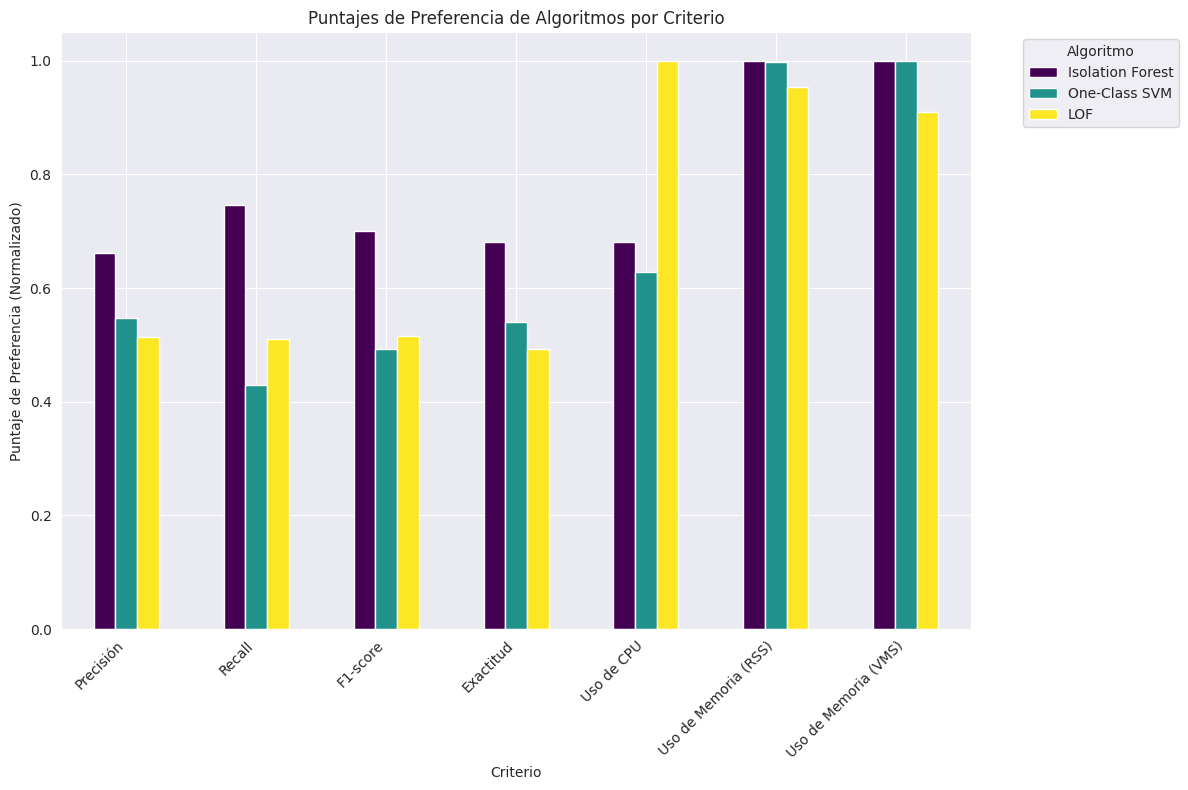

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Algoritmos y criterios
algoritmos = ['Isolation Forest', 'One-Class SVM', 'LOF']
criterios = ['Precisión', 'Recall', 'F1-score', 'Exactitud', 'Uso de CPU', 'Uso de Memoria (RSS)', 'Uso de Memoria (VMS)']

# Matriz normalizada para cada criterio y algoritmo
matriz_normalizada = np.array([
    [0.66127199, 0.54725958, 0.51305585],
    [0.74532491, 0.42881707, 0.51049652],
    [0.70122513, 0.49304892, 0.51496221],
    [0.6814575 , 0.54046629, 0.49346922],
    [0.68085106, 0.62745098, 1.        ],
    [1.        , 0.99741888, 0.95459358],
    [1.        , 1.        , 0.90902081]
])

# Crear un DataFrame para facilitar la creación de gráficos
df_matriz = pd.DataFrame(matriz_normalizada, columns=algoritmos, index=criterios)

# Crear la gráfica de barras para los puntajes de preferencia por cada criterio
df_matriz.plot(kind='bar', figsize=(12, 8), colormap='viridis')

# Añadir título y etiquetas
plt.title('Puntajes de Preferencia de Algoritmos por Criterio')
plt.ylabel('Puntaje de Preferencia (Normalizado)')
plt.xlabel('Criterio')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Algoritmo', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


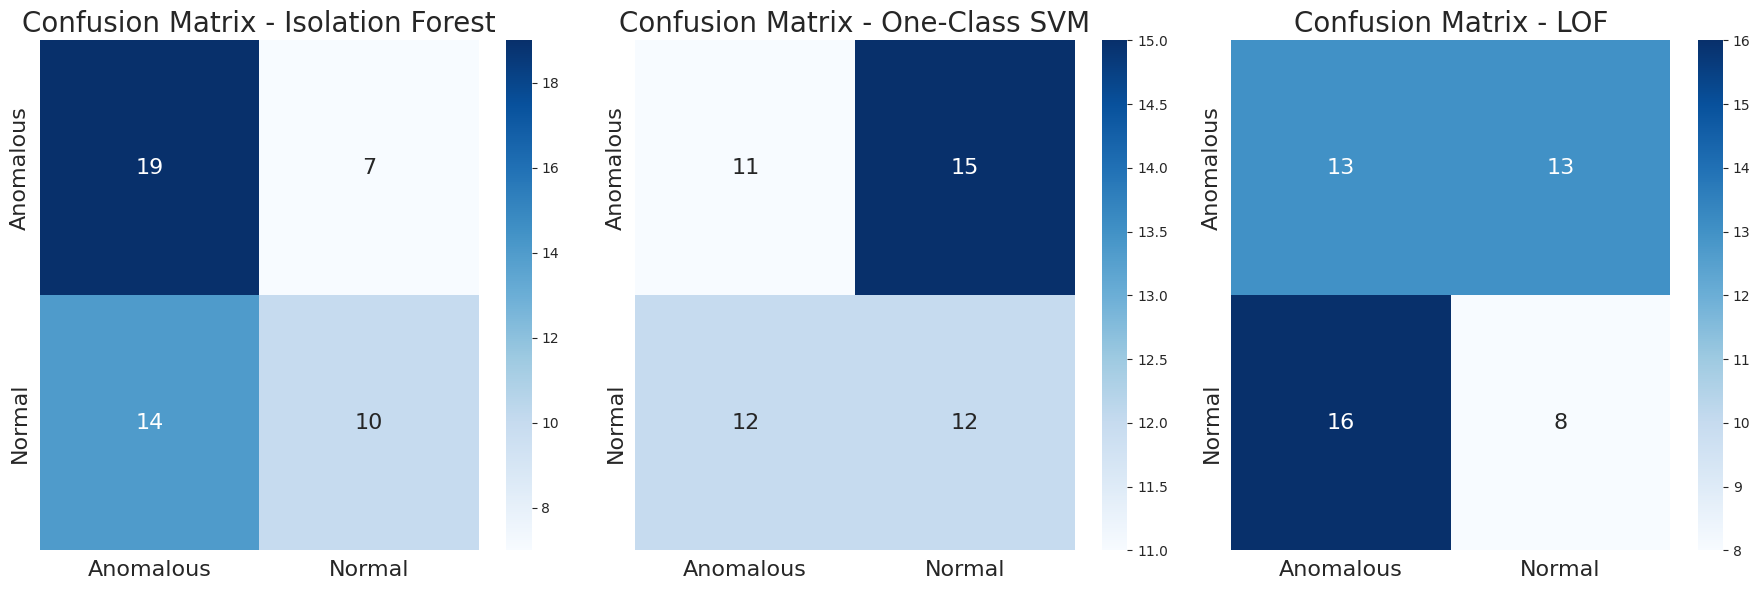

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Datos para las matrices de confusión
conf_matrix1 = np.array([[19, 7], [14, 10]])
conf_matrix2 = np.array([[11, 15], [12, 12]])
conf_matrix3 = np.array([[13, 13], [16, 8]])

# Configurar el tamaño de la figura
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Etiquetas
labels = ['Anomalous', 'Normal']

# Crear las matrices de confusión
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 16})  # Aumenta el tamaño de los números
axes[0].set_title('Confusion Matrix - Isolation Forest',fontsize=20)# en ingles Confusion Matrix
axes[0].set_xticklabels(labels, fontsize=16)  # Aumenta el tamaño de las etiquetas del eje x
axes[0].set_yticklabels(labels, fontsize=16)

sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 16})  # Aumenta el tamaño de los números
axes[1].set_title('Confusion Matrix - One-Class SVM',fontsize=20)
axes[1].set_xticklabels(labels, fontsize=16)  # Aumenta el tamaño de las etiquetas del eje x
axes[1].set_yticklabels(labels, fontsize=16)

sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 16})  # Aumenta el tamaño de los números
axes[2].set_title('Confusion Matrix - LOF',fontsize=20)
axes[2].set_xticklabels(labels, fontsize=16)  # Aumenta el tamaño de las etiquetas del eje x
axes[2].set_yticklabels(labels, fontsize=16)

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [41]:
import numpy as np
import pandas as pd

# Datos
pesos = np.array([0.2, 0.2, 0.2, 0.2, 0.1, 0.05, 0.05])
valores = {
    'Isolation Forest': [0.58, 0.41, 0.49, 0.58, 0.17, 254.78, 1255.29],
    'SVM': [0.48, 0.54, 0.51, 0.50, 0.01, 254.90, 1255.29],
    'LOF': [0.38, 0.33, 0.35, 0.42, 0.00, 254.90, 1255.29]
}
algoritmos = list(valores.keys())
valores_np = np.array(list(valores.values()))

# Normalización
def normalizar(data):
    norm_data = np.linalg.norm(data, axis=0)
    return data / norm_data

valores_normalizados = normalizar(valores_np)

# Soluciones ideales
solucion_ideal_positiva = np.max(valores_normalizados, axis=0)
solucion_ideal_negativa = np.min(valores_normalizados, axis=0)

# Distancias
def calcular_distancias(valores, s_positiva, s_negativa):
    dist_positiva = np.linalg.norm(valores - s_positiva, axis=1)
    dist_negativa = np.linalg.norm(valores - s_negativa, axis=1)
    return dist_positiva, dist_negativa

dist_positiva, dist_negativa = calcular_distancias(valores_normalizados, solucion_ideal_positiva, solucion_ideal_negativa)

# Puntaje de Preferencia
puntaje_preferencia = dist_negativa / (dist_positiva + dist_negativa)

# Resultados
resultados = pd.DataFrame({
    'Puntaje de Preferencia': puntaje_preferencia
}, index=algoritmos)

print(resultados)


                  Puntaje de Preferencia
Isolation Forest                0.859113
SVM                             0.285528
LOF                             0.000248


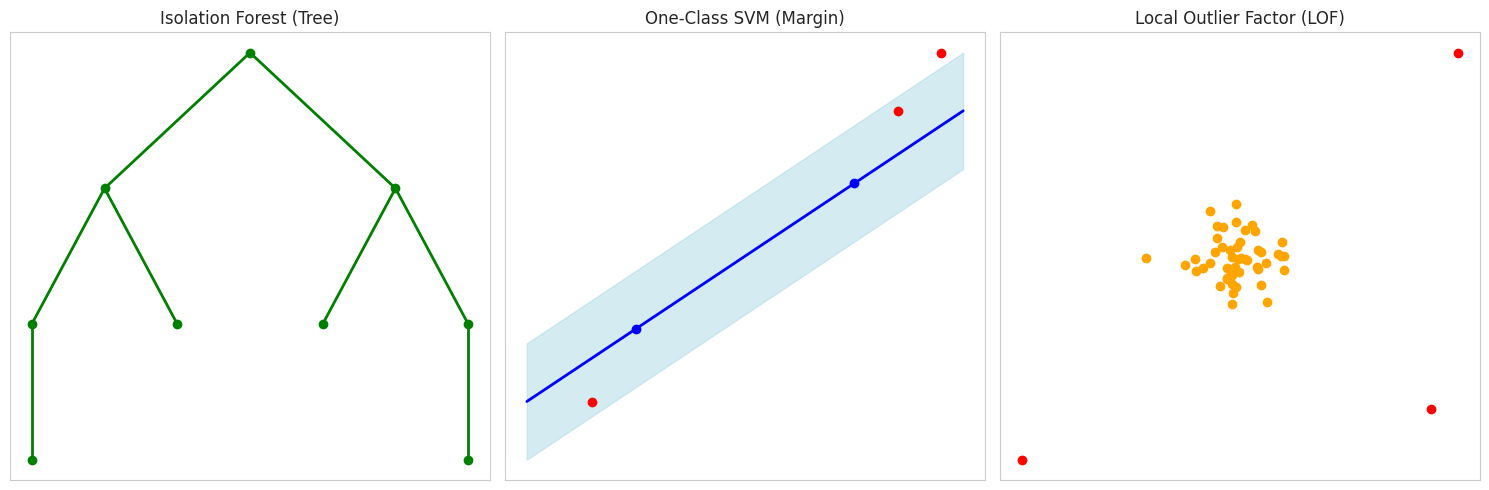

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Configuración del tamaño de las figuras
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 1. Visualización para Isolation Forest (Árbol)
# Representación simple de un árbol binario
axs[0].plot([0.5, 0.3], [0.8, 0.6], color='green', lw=2)
axs[0].plot([0.5, 0.7], [0.8, 0.6], color='green', lw=2)
axs[0].plot([0.3, 0.2], [0.6, 0.4], color='green', lw=2)
axs[0].plot([0.3, 0.4], [0.6, 0.4], color='green', lw=2)
axs[0].plot([0.7, 0.6], [0.6, 0.4], color='green', lw=2)
axs[0].plot([0.7, 0.8], [0.6, 0.4], color='green', lw=2)
axs[0].plot([0.2, 0.2], [0.4, 0.2], color='green', lw=2)
axs[0].plot([0.8, 0.8], [0.4, 0.2], color='green', lw=2)
axs[0].scatter([0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.8, 0.2, 0.8], 
               [0.8, 0.6, 0.6, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2], color='green')
axs[0].set_title("Isolation Forest (Tree)", fontsize=12)
axs[0].set_xticks([])
axs[0].set_yticks([])

# 2. Visualización para One-Class SVM (Plano con margen)
# Representación de un margen con un hiperplano separador
x = np.linspace(-1, 1, 100)
y = 0.5 * x
axs[1].plot(x, y, color='blue', lw=2)  # Hiperplano
axs[1].fill_between(x, y + 0.2, y - 0.2, color='lightblue', alpha=0.5)  # Margen
axs[1].scatter([-0.5, 0.5], [-0.25, 0.25], color='blue')  # Puntos de soporte
axs[1].scatter([0.7, -0.7, 0.9], [0.5, -0.5, 0.7], color='red')  # Puntos fuera del margen
axs[1].set_title("One-Class SVM (Margin)", fontsize=12)
axs[1].set_xticks([])
axs[1].set_yticks([])

# 3. Visualización para LOF (Grupos de puntos con outliers)
# Representación de puntos densos y outliers
group = np.random.normal(loc=0, scale=0.1, size=(50, 2))
outliers = np.array([[0.8, 0.8], [-0.8, -0.8], [0.7, -0.6]])
axs[2].scatter(group[:, 0], group[:, 1], color='orange')
axs[2].scatter(outliers[:, 0], outliers[:, 1], color='red')  # Outliers
axs[2].set_title("Local Outlier Factor (LOF)", fontsize=12)
axs[2].set_xticks([])
axs[2].set_yticks([])

# Ajustes finales
plt.tight_layout()
plt.show()
